<a href="https://colab.research.google.com/github/Adil1979/P6_Tag_Recommendation_Stackoverflow/blob/master/01_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Projet6: Catégorisation automatique de questions**

## **1.Librairies**

In [ ]:
!pip install feature_engine

In [ ]:
!pip install plotly

In [ ]:
!pip install chart-studio

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D
import matplotlib as mpl
import chart_studio.plotly.plotly as py
#import plotly.plotly as py
import seaborn as sns
import datetime as dt
import calendar as cld
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from os import listdir
import glob
import missingno as msno
from feature_engine.categorical_encoders import OneHotCategoricalEncoder
from sklearn.decomposition import PCA
from matplotlib import dates
import nltk
import re
from nltk.corpus import stopwords 
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer 
import string
from collections import Counter
from bs4 import BeautifulSoup

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


SELECT Id, Body, Title, Tags

FROM Posts

WHERE Score >= 3 AND PostTypeId = 1

ORDER BY RAND()
 
ASC OFFSET 0 ROWS FETCH NEXT 50000 ROWS ONLY; de 0 à 50000

## **2.Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_analysis_01 = pd.read_csv('/content/drive/My Drive/CentraleSupelec_OCR/P6/QueryResults_01.csv')
df_analysis_01.head()

,Id,Body,Title,Tags,CreationDate
0,50158677,<p>I know that they are a lot of other questio...,Error creating bean with name 'usersDao': Unsa...,<java><hibernate><spring-mvc><autowired><sessi...,2018-05-03 15:23:33
1,49557177,"<p>I ran into a problem the other day, and ask...",vuex- state returned as function or object lit...,<javascript><vue.js><vuejs2><vuex>,2018-03-29 13:20:15
2,48743662,<p>I have 2 dataframes with the following form...,Python Pandas - Merge based on substring in st...,<python><pandas><dataframe>,2018-02-12 09:57:19
3,48743723,<p>I have strings which represent versions (al...,How to replace the last char of a string in ba...,<bash>,2018-02-12 10:00:55
4,48743733,<p>So I'm trying to write part of some code fo...,Running CameraBridgeViewBase as a service to d...,<java><android><opencv><service><camera>,2018-02-12 10:01:34


In [ ]:
df_analysis_01.shape

(50000, 5)

In [ ]:
df_analysis_02 = pd.read_csv('/content/drive/My Drive/CentraleSupelec_OCR/P6/QueryResults_02.csv')
df_analysis_02.head()

,Id,Body,Title,Tags,CreationDate
0,51356212,"<p>In Puppeteer, <code>page.evaluate</code> th...",Pass Class as an Argument to page.evaluate in ...,<javascript><puppeteer>,2018-07-16 06:59:00
1,51356259,<p>I have a string:</p>\n\n<pre><code>Hi there...,"Kotlin String.split, ignore when delimiter is ...",<string><split><kotlin>,2018-07-16 07:03:02
2,51356324,<p>I would like to know whether is it possible...,RDKit - Export pandas data frame with mol image,<pandas><rdkit>,2018-07-16 07:08:15
3,51356330,<p>I have a continuous dependent variable y an...,How to interpret the summary table for Python ...,<python><statistics><statsmodels><anova>,2018-07-16 07:08:28
4,51356338,<p>I'm working on a Web project where the clie...,Converting JSON to table in SQL Server 2016,<json><sql-server-2016>,2018-07-16 07:08:59


In [ ]:
df_analysis_02.shape

(50000, 5)

In [ ]:
df_analysis_03 = pd.read_csv('/content/drive/My Drive/CentraleSupelec_OCR/P6/QueryResults_03.csv')
df_analysis_03.head()

,Id,Body,Title,Tags,CreationDate
0,52021405,<p>I am currently trying to create a simple SP...,Vue.js / Laravel - Handle logout correctly,<php><laravel><vue.js><vuejs2>,2018-08-25 21:33:54
1,52021452,"<p>In my application, I want to allow the user...",Remove the Name from a WPF control,<c#><wpf><xaml>,2018-08-25 21:41:37
2,58528619,<p>I have a large data set with individual col...,Converting `dttm` to `date` formatting with as...,<r><tidyverse><lubridate>,2019-10-23 18:02:10
3,59810062,<p>I found an unexpected value of <em>this</em...,The value of `this` keyword of a function retu...,<javascript><getter-setter>,2020-01-19 12:36:00
4,59810118,<p>I have created .xcframework and trying to u...,Error:The use of xcframeworks is not supported...,<swift><xcode><xcframework>,2020-01-19 12:44:58


In [ ]:
df_analysis_03.shape

(50000, 5)

In [ ]:
frames = [df_analysis_01, df_analysis_02, df_analysis_03]

In [ ]:
df_analysis = pd.concat(frames)
df_analysis.head(10)

,Id,Body,Title,Tags,CreationDate
0,50158677,<p>I know that they are a lot of other questio...,Error creating bean with name 'usersDao': Unsa...,<java><hibernate><spring-mvc><autowired><sessi...,2018-05-03 15:23:33
1,49557177,"<p>I ran into a problem the other day, and ask...",vuex- state returned as function or object lit...,<javascript><vue.js><vuejs2><vuex>,2018-03-29 13:20:15
2,48743662,<p>I have 2 dataframes with the following form...,Python Pandas - Merge based on substring in st...,<python><pandas><dataframe>,2018-02-12 09:57:19
3,48743723,<p>I have strings which represent versions (al...,How to replace the last char of a string in ba...,<bash>,2018-02-12 10:00:55
4,48743733,<p>So I'm trying to write part of some code fo...,Running CameraBridgeViewBase as a service to d...,<java><android><opencv><service><camera>,2018-02-12 10:01:34
5,48743740,"<p>Recently, we have migrated Hybris 5.4 to Hy...",Hybris generates an existing PK,<java><hybris>,2018-02-12 10:02:08
6,48744116,"<p><strong>Append</strong> <code>,</code> says...","How does Append (,) work?",<j>,2018-02-12 10:22:15
7,48744127,<p>I try to set up a MenuItem with an <code>ac...,How to set expanded ActionView's width in Supp...,<android><android-layout><android-actionbar>,2018-02-12 10:22:52
8,48744146,<p>I'm currently stacking Futures and Eithers ...,"Stacking M, Either and Writer",<scala><monads><monad-transformers><scala-cats>,2018-02-12 10:24:16
9,48744165,"<p>What is the best way to create a (3,3) subp...",Uneven subplot in python,<python><matplotlib><subplot>,2018-02-12 10:25:35


In [ ]:
df_analysis.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Id            150000 non-null  int64 
 1   Body          150000 non-null  object
 2   Title         150000 non-null  object
 3   Tags          150000 non-null  object
 4   CreationDate  150000 non-null  object
dtypes: int64(1), object(4)
memory usage: 6.9+ MB


In [ ]:
df_analysis = df_analysis.loc[:, ['Id', 'Title', 'Body', 'Tags']]
df_analysis = df_analysis.set_index('Id')
df_analysis.head()

,Title,Body,Tags
Id,,,
50158677,Error creating bean with name 'usersDao': Unsa...,<p>I know that they are a lot of other questio...,<java><hibernate><spring-mvc><autowired><sessi...
49557177,vuex- state returned as function or object lit...,"<p>I ran into a problem the other day, and ask...",<javascript><vue.js><vuejs2><vuex>
48743662,Python Pandas - Merge based on substring in st...,<p>I have 2 dataframes with the following form...,<python><pandas><dataframe>
48743723,How to replace the last char of a string in ba...,<p>I have strings which represent versions (al...,<bash>
48743733,Running CameraBridgeViewBase as a service to d...,<p>So I'm trying to write part of some code fo...,<java><android><opencv><service><camera>


## **3.Preprocessing**

In [ ]:
df_analysis.duplicated(subset=["Body", "Title"]).sum()

0

In [ ]:
example_body = df_analysis.Body.iloc[0]

In [ ]:
example_body

'<p>I know that they are a lot of other questions like mine, but I don\'t seem to find the answer that I need. I\'m new to Spring and Hibernate, so I don\'t understand much yet. I\'m using Jetty Runner. Anyway, I was going to start to use Hibernate in my application and I had this error:</p>\n\n<pre><code>2018-05-03 15:37:03 ERROR ContextLoader:316 - Context initialization failed\norg.springframework.beans.factory.UnsatisfiedDependencyException: Error creating bean with name \'usersDao\': Unsatisfied dependency expressed through field \'sessionFactory\'; nested exception is org.springframework.beans.factory.NoSuchBeanDefinitionException: No qualifying bean of type \'org.springframework.orm.hibernate5.LocalSessionFactoryBean\' available: expected at least 1 bean which qualifies as autowire candidate. Dependency annotations: {@org.springframework.beans.factory.annotation.Autowired(required=true)}\nat org.springframework.beans.factory.annotation.AutowiredAnnotationBeanPostProcessor$Autowi

In [ ]:
example_title = df_analysis.Title.iloc[0]

In [ ]:
example_title

"Error creating bean with name 'usersDao': Unsatisfied dependency expressed through field 'sessionFactory'"

In [ ]:

#Merge Title and Body
df_analysis['Title_Body'] = df_analysis['Title'] + ' ' + df_analysis['Body']

In [ ]:
df_analysis.head()


,Title,Body,Tags,Title_Body
Id,,,,
50158677,Error creating bean with name 'usersDao': Unsa...,<p>I know that they are a lot of other questio...,<java><hibernate><spring-mvc><autowired><sessi...,Error creating bean with name 'usersDao': Unsa...
49557177,vuex- state returned as function or object lit...,"<p>I ran into a problem the other day, and ask...",<javascript><vue.js><vuejs2><vuex>,vuex- state returned as function or object lit...
48743662,Python Pandas - Merge based on substring in st...,<p>I have 2 dataframes with the following form...,<python><pandas><dataframe>,Python Pandas - Merge based on substring in st...
48743723,How to replace the last char of a string in ba...,<p>I have strings which represent versions (al...,<bash>,How to replace the last char of a string in ba...
48743733,Running CameraBridgeViewBase as a service to d...,<p>So I'm trying to write part of some code fo...,<java><android><opencv><service><camera>,Running CameraBridgeViewBase as a service to d...


In [ ]:
variables_reorganization = ['Title_Body', 'Tags']
df_analysis = df_analysis[['Title_Body', 'Tags']]

In [ ]:
df_analysis.head()

,Title_Body,Tags
Id,,
50158677,Error creating bean with name 'usersDao': Unsa...,<java><hibernate><spring-mvc><autowired><sessi...
49557177,vuex- state returned as function or object lit...,<javascript><vue.js><vuejs2><vuex>
48743662,Python Pandas - Merge based on substring in st...,<python><pandas><dataframe>
48743723,How to replace the last char of a string in ba...,<bash>
48743733,Running CameraBridgeViewBase as a service to d...,<java><android><opencv><service><camera>


In [ ]:
df_analysis.Title_Body.iloc[0]

'Error creating bean with name \'usersDao\': Unsatisfied dependency expressed through field \'sessionFactory\' <p>I know that they are a lot of other questions like mine, but I don\'t seem to find the answer that I need. I\'m new to Spring and Hibernate, so I don\'t understand much yet. I\'m using Jetty Runner. Anyway, I was going to start to use Hibernate in my application and I had this error:</p>\n\n<pre><code>2018-05-03 15:37:03 ERROR ContextLoader:316 - Context initialization failed\norg.springframework.beans.factory.UnsatisfiedDependencyException: Error creating bean with name \'usersDao\': Unsatisfied dependency expressed through field \'sessionFactory\'; nested exception is org.springframework.beans.factory.NoSuchBeanDefinitionException: No qualifying bean of type \'org.springframework.orm.hibernate5.LocalSessionFactoryBean\' available: expected at least 1 bean which qualifies as autowire candidate. Dependency annotations: {@org.springframework.beans.factory.annotation.Autowire

In [ ]:
#HTML characters removing
def remove_html(body):
  html_regex = re.compile('<.*?>') #Compile regular expresions
  return re.sub(html_regex, ' ', str(body)) # Replace regex by ' '

In [ ]:
df_analysis['Title_Body'] = df_analysis['Title_Body'].apply(remove_html)
df_analysis.head()

,Title_Body,Tags
Id,,
50158677,Error creating bean with name 'usersDao': Unsa...,<java><hibernate><spring-mvc><autowired><sessi...
49557177,vuex- state returned as function or object lit...,<javascript><vue.js><vuejs2><vuex>
48743662,Python Pandas - Merge based on substring in st...,<python><pandas><dataframe>
48743723,How to replace the last char of a string in ba...,<bash>
48743733,Running CameraBridgeViewBase as a service to d...,<java><android><opencv><service><camera>


In [ ]:
df_analysis.Title_Body.iloc[0]

'Error creating bean with name \'usersDao\': Unsatisfied dependency expressed through field \'sessionFactory\'  I know that they are a lot of other questions like mine, but I don\'t seem to find the answer that I need. I\'m new to Spring and Hibernate, so I don\'t understand much yet. I\'m using Jetty Runner. Anyway, I was going to start to use Hibernate in my application and I had this error: \n\n  2018-05-03 15:37:03 ERROR ContextLoader:316 - Context initialization failed\norg.springframework.beans.factory.UnsatisfiedDependencyException: Error creating bean with name \'usersDao\': Unsatisfied dependency expressed through field \'sessionFactory\'; nested exception is org.springframework.beans.factory.NoSuchBeanDefinitionException: No qualifying bean of type \'org.springframework.orm.hibernate5.LocalSessionFactoryBean\' available: expected at least 1 bean which qualifies as autowire candidate. Dependency annotations: {@org.springframework.beans.factory.annotation.Autowired(required=tru

In [ ]:
#URL removing
def remove_url(body):
  url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
  return re.sub(url_regex, ' ', str(body))  

In [ ]:
df_analysis['Title_Body'] = df_analysis['Title_Body'].apply(remove_url)
df_analysis.head()

,Title_Body,Tags
Id,,
50158677,Error creating bean with name 'usersDao': Unsa...,<java><hibernate><spring-mvc><autowired><sessi...
49557177,vuex- state returned as function or object lit...,<javascript><vue.js><vuejs2><vuex>
48743662,Python Pandas - Merge based on substring in st...,<python><pandas><dataframe>
48743723,How to replace the last char of a string in ba...,<bash>
48743733,Running CameraBridgeViewBase as a service to d...,<java><android><opencv><service><camera>


In [ ]:
df_analysis.Title_Body.iloc[0]

'Error creating bean with name \'usersDao\': Unsatisfied dependency expressed through field \'sessionFactory\'  I know that they are a lot of other questions like mine, but I don\'t seem to find the answer that I need. I\'m new to Spring and Hibernate, so I don\'t understand much yet. I\'m using Jetty Runner. Anyway, I was going to start to use Hibernate in my application and I had this error: \n\n  2018-05-03 15:37:03 ERROR ContextLoader:316 - Context initialization failed\norg.springframework.beans.factory.UnsatisfiedDependencyException: Error creating bean with name \'usersDao\': Unsatisfied dependency expressed through field \'sessionFactory\'; nested exception is org.springframework.beans.factory.NoSuchBeanDefinitionException: No qualifying bean of type \'org.springframework.orm.hibernate5.LocalSessionFactoryBean\' available: expected at least 1 bean which qualifies as autowire candidate. Dependency annotations: {@org.springframework.beans.factory.annotation.Autowired(required=tru

In [ ]:
#Punctuation removing
def remove_punc(body):
  clean_text = re.sub(r'[?|!|"|:|=|_|{|}|[|]|-|$|%|^|&|]',r' ',str(body))
  clean_text = re.sub(r'[.|,|)|(|\|/|-|~|`|>|<|*|$|@|;|→]',r' ', clean_text)
  return clean_text

In [ ]:
df_analysis['Title_Body'] = df_analysis['Title_Body'].apply(remove_punc)

In [ ]:

df_analysis.Title_Body.iloc[0]

" Error creating bean with name 'usersDao'  Unsatisfied dependency expressed through field 'sessionFactory'  I know that they are a lot of other questions like mine  but I don't seem to find the answer that I need  I'm new to Spring and Hibernate  so I don't understand much yet  I'm using Jetty Runner  Anyway  I was going to start to use Hibernate in my application and I had this error  \n\n  2018 05 03 15 37 03 ERROR ContextLoader 316   Context initialization failed\norg springframework beans factory UnsatisfiedDependencyException  Error creating bean with name 'usersDao'  Unsatisfied dependency expressed through field 'sessionFactory'  nested exception is org springframework beans factory NoSuchBeanDefinitionException  No qualifying bean of type 'org springframework orm hibernate5 LocalSessionFactoryBean' available  expected at least 1 bean which qualifies as autowire candidate  Dependency annotations    org springframework beans factory annotation Autowired required true  \nat org s

In [ ]:
#All characters removing except letters, numbers 
#Lower
def remove_other(body):
  text = str(body)
  clean_text = re.sub(r"[^a-zA-Z0-9#+-]", " ", text.lower())
  return clean_text

In [ ]:
df_analysis['Title_Body'] = df_analysis['Title_Body'].apply(remove_other)
df_analysis.head()

,Title_Body,Tags
Id,,
50158677,error creating bean with name usersdao uns...,<java><hibernate><spring-mvc><autowired><sessi...
49557177,vuex state returned as function or object li...,<javascript><vue.js><vuejs2><vuex>
48743662,python pandas merge based on substring in s...,<python><pandas><dataframe>
48743723,how to replace the last char of a string in b...,<bash>
48743733,running camerabridgeviewbase as a service to ...,<java><android><opencv><service><camera>


In [ ]:
df_analysis.Title_Body.iloc[0]

' error creating bean with name  usersdao   unsatisfied dependency expressed through field  sessionfactory   i know that they are a lot of other questions like mine  but i don t seem to find the answer that i need  i m new to spring and hibernate  so i don t understand much yet  i m using jetty runner  anyway  i was going to start to use hibernate in my application and i had this error      2018 05 03 15 37 03 error contextloader 316   context initialization failed org springframework beans factory unsatisfieddependencyexception  error creating bean with name  usersdao   unsatisfied dependency expressed through field  sessionfactory   nested exception is org springframework beans factory nosuchbeandefinitionexception  no qualifying bean of type  org springframework orm hibernate5 localsessionfactorybean  available  expected at least 1 bean which qualifies as autowire candidate  dependency annotations    org springframework beans factory annotation autowired required true   at org sprin

In [ ]:
#Space removing
def remove_space(body):
  return ' '.join(str(body).split()) 

In [ ]:
df_analysis['Title_Body'] = df_analysis['Title_Body'].apply(remove_space)

In [ ]:
df_analysis.Title_Body.iloc[0]

'error creating bean with name usersdao unsatisfied dependency expressed through field sessionfactory i know that they are a lot of other questions like mine but i don t seem to find the answer that i need i m new to spring and hibernate so i don t understand much yet i m using jetty runner anyway i was going to start to use hibernate in my application and i had this error 2018 05 03 15 37 03 error contextloader 316 context initialization failed org springframework beans factory unsatisfieddependencyexception error creating bean with name usersdao unsatisfied dependency expressed through field sessionfactory nested exception is org springframework beans factory nosuchbeandefinitionexception no qualifying bean of type org springframework orm hibernate5 localsessionfactorybean available expected at least 1 bean which qualifies as autowire candidate dependency annotations org springframework beans factory annotation autowired required true at org springframework beans factory annotation a

In [ ]:
#df_analysis['Title_Body_count'] = df_analysis['Title_Body'].apply(lambda text: len(text.split(" ")))

In [ ]:
df_analysis.head()

,Title_Body,Tags
Id,,
50158677,error creating bean with name usersdao unsatis...,<java><hibernate><spring-mvc><autowired><sessi...
49557177,vuex state returned as function or object lite...,<javascript><vue.js><vuejs2><vuex>
48743662,python pandas merge based on substring in stri...,<python><pandas><dataframe>
48743723,how to replace the last char of a string in ba...,<bash>
48743733,running camerabridgeviewbase as a service to d...,<java><android><opencv><service><camera>


In [ ]:
#Tokenization
nltk.download("punkt")
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df_analysis["tokenized_Title_Body"] = df_analysis["Title_Body"].apply(word_tokenize)

In [ ]:
df_analysis.head()

,Title_Body,Tags,tokenized_Title_Body
Id,,,
50158677,error creating bean with name usersdao unsatis...,<java><hibernate><spring-mvc><autowired><sessi...,"[error, creating, bean, with, name, usersdao, ..."
49557177,vuex state returned as function or object lite...,<javascript><vue.js><vuejs2><vuex>,"[vuex, state, returned, as, function, or, obje..."
48743662,python pandas merge based on substring in stri...,<python><pandas><dataframe>,"[python, pandas, merge, based, on, substring, ..."
48743723,how to replace the last char of a string in ba...,<bash>,"[how, to, replace, the, last, char, of, a, str..."
48743733,running camerabridgeviewbase as a service to d...,<java><android><opencv><service><camera>,"[running, camerabridgeviewbase, as, a, service..."


In [ ]:
df_analysis.tokenized_Title_Body.iloc[0]

['error',
 'creating',
 'bean',
 'with',
 'name',
 'usersdao',
 'unsatisfied',
 'dependency',
 'expressed',
 'through',
 'field',
 'sessionfactory',
 'i',
 'know',
 'that',
 'they',
 'are',
 'a',
 'lot',
 'of',
 'other',
 'questions',
 'like',
 'mine',
 'but',
 'i',
 'don',
 't',
 'seem',
 'to',
 'find',
 'the',
 'answer',
 'that',
 'i',
 'need',
 'i',
 'm',
 'new',
 'to',
 'spring',
 'and',
 'hibernate',
 'so',
 'i',
 'don',
 't',
 'understand',
 'much',
 'yet',
 'i',
 'm',
 'using',
 'jetty',
 'runner',
 'anyway',
 'i',
 'was',
 'going',
 'to',
 'start',
 'to',
 'use',
 'hibernate',
 'in',
 'my',
 'application',
 'and',
 'i',
 'had',
 'this',
 'error',
 '2018',
 '05',
 '03',
 '15',
 '37',
 '03',
 'error',
 'contextloader',
 '316',
 'context',
 'initialization',
 'failed',
 'org',
 'springframework',
 'beans',
 'factory',
 'unsatisfieddependencyexception',
 'error',
 'creating',
 'bean',
 'with',
 'name',
 'usersdao',
 'unsatisfied',
 'dependency',
 'expressed',
 'through',
 'field',


In [ ]:
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

In [ ]:
def remove_stopwords(text_rows):
  corpus = []
  for word in text_rows:
    if word not in stop_words:
      corpus.append(ps.stem(word))
  return corpus

In [ ]:
df_analysis['tokenized_Title_Body'] = df_analysis['tokenized_Title_Body'].apply(remove_stopwords)

In [ ]:
df_analysis.tokenized_Title_Body.iloc[0]

['error',
 'creat',
 'bean',
 'name',
 'usersdao',
 'unsatisfi',
 'depend',
 'express',
 'field',
 'sessionfactori',
 'know',
 'lot',
 'question',
 'like',
 'mine',
 'seem',
 'find',
 'answer',
 'need',
 'new',
 'spring',
 'hibern',
 'understand',
 'much',
 'yet',
 'use',
 'jetti',
 'runner',
 'anyway',
 'go',
 'start',
 'use',
 'hibern',
 'applic',
 'error',
 '2018',
 '05',
 '03',
 '15',
 '37',
 '03',
 'error',
 'contextload',
 '316',
 'context',
 'initi',
 'fail',
 'org',
 'springframework',
 'bean',
 'factori',
 'unsatisfieddependencyexcept',
 'error',
 'creat',
 'bean',
 'name',
 'usersdao',
 'unsatisfi',
 'depend',
 'express',
 'field',
 'sessionfactori',
 'nest',
 'except',
 'org',
 'springframework',
 'bean',
 'factori',
 'nosuchbeandefinitionexcept',
 'qualifi',
 'bean',
 'type',
 'org',
 'springframework',
 'orm',
 'hibernate5',
 'localsessionfactorybean',
 'avail',
 'expect',
 'least',
 '1',
 'bean',
 'qualifi',
 'autowir',
 'candid',
 'depend',
 'annot',
 'org',
 'springfram

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vectorizer = TfidfVectorizer(lowercase=False)
ttb_tfidf = vectorizer.fit_transform(df_analysis['tokenized_Title_Body'])

TypeError: ignored

In [ ]:
df_analysis.tokenized_Title_Body.iloc[0]

['error',
 'creat',
 'bean',
 'name',
 'usersdao',
 'unsatisfi',
 'depend',
 'express',
 'field',
 'sessionfactori',
 'know',
 'lot',
 'question',
 'like',
 'mine',
 'seem',
 'find',
 'answer',
 'need',
 'new',
 'spring',
 'hibern',
 'understand',
 'much',
 'yet',
 'use',
 'jetti',
 'runner',
 'anyway',
 'go',
 'start',
 'use',
 'hibern',
 'applic',
 'error',
 '2018',
 '05',
 '03',
 '15',
 '37',
 '03',
 'error',
 'contextload',
 '316',
 'context',
 'initi',
 'fail',
 'org',
 'springframework',
 'bean',
 'factori',
 'unsatisfieddependencyexcept',
 'error',
 'creat',
 'bean',
 'name',
 'usersdao',
 'unsatisfi',
 'depend',
 'express',
 'field',
 'sessionfactori',
 'nest',
 'except',
 'org',
 'springframework',
 'bean',
 'factori',
 'nosuchbeandefinitionexcept',
 'qualifi',
 'bean',
 'type',
 'org',
 'springframework',
 'orm',
 'hibernate5',
 'localsessionfactorybean',
 'avail',
 'expect',
 'least',
 '1',
 'bean',
 'qualifi',
 'autowir',
 'candid',
 'depend',
 'annot',
 'org',
 'springfram

In [ ]:
df_analysis = df_analysis.loc[:,['Title_Body', 'tokenized_Title_Body', 'Tags']]

In [ ]:
df_analysis

,Title_Body,tokenized_Title_Body,Tags
Id,,,
50158677,error creating bean with name usersdao unsatis...,"[error, creat, bean, name, usersdao, unsatisfi...",<java><hibernate><spring-mvc><autowired><sessi...
49557177,vuex state returned as function or object lite...,"[vuex, state, return, function, object, liter,...",<javascript><vue.js><vuejs2><vuex>
48743662,python pandas merge based on substring in stri...,"[python, panda, merg, base, substr, string, 2,...",<python><pandas><dataframe>
48743723,how to replace the last char of a string in ba...,"[replac, last, char, string, bash, anoth, char...",<bash>
48743733,running camerabridgeviewbase as a service to d...,"[run, camerabridgeviewbas, servic, movement, d...",<java><android><opencv><service><camera>
...,...,...,...
52865279,why numpy fft return incorrect phase informati...,"[numpi, fft, return, incorrect, phase, inform,...",<python><matlab><numpy><spectrum><phase>
52865323,how to count missing data in each column in py...,"[count, miss, data, column, python, larg, data...",<python>
52744463,how to select latest record in group using jpq...,"[select, latest, record, group, use, jpql, spr...",<jpa><spring-data-jpa><spring-data><jpql><spri...


In [ ]:
df_analysis.Tags.iloc[0]

'<java><hibernate><spring-mvc><autowired><sessionfactory>'

In [ ]:
# convert data to list
to_list = {'><': "','",'<':"['", '>':"']"}
for key, value in to_list.items():
  df_analysis['Tags'] = df_analysis['Tags'].str.replace(key, value)

In [ ]:
df_analysis.head()

,Title_Body,tokenized_Title_Body,Tags
Id,,,
50158677,error creating bean with name usersdao unsatis...,"[error, creat, bean, name, usersdao, unsatisfi...","['java','hibernate','spring-mvc','autowired','..."
49557177,vuex state returned as function or object lite...,"[vuex, state, return, function, object, liter,...","['javascript','vue.js','vuejs2','vuex']"
48743662,python pandas merge based on substring in stri...,"[python, panda, merg, base, substr, string, 2,...","['python','pandas','dataframe']"
48743723,how to replace the last char of a string in ba...,"[replac, last, char, string, bash, anoth, char...",['bash']
48743733,running camerabridgeviewbase as a service to d...,"[run, camerabridgeviewbas, servic, movement, d...","['java','android','opencv','service','camera']"


In [ ]:
tags = df_analysis['Tags'].tolist()

In [ ]:
tags

["['java','hibernate','spring-mvc','autowired','sessionfactory']",
 "['javascript','vue.js','vuejs2','vuex']",
 "['python','pandas','dataframe']",
 "['bash']",
 "['java','android','opencv','service','camera']",
 "['java','hybris']",
 "['j']",
 "['android','android-layout','android-actionbar']",
 "['scala','monads','monad-transformers','scala-cats']",
 "['python','matplotlib','subplot']",
 "['selenium','xpath','webdriver','selenium-chromedriver']",
 "['gradle','code-coverage','bamboo','jacoco']",
 "['time','rust']",
 "['javascript','node.js','express']",
 "['c#','asp.net-core']",
 "['python','pandas','jupyter-notebook']",
 "['spring','spring-boot','logging','gradle','log4j2']",
 "['android','firebase','firebase-analytics']",
 "['apache-kafka']",
 "['java','python','c++','opencv','computer-vision']",
 "['powershell','visual-studio-code']",
 "['android','kotlin','android-databinding']",
 "['css','symfony','deployment','routing']",
 "['php','sql','laravel','laravel-5.8']",
 "['formatting',

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer # Convert a collection of text documents to a matrix of token counts

In [ ]:
cv = CountVectorizer(max_features = 50) #, analyzer= 'word', stop_words= 'english')
tags_vec = cv.fit_transform(tags).toarray()
print('Number of tags: ', len(cv.vocabulary_))
tags_name = cv.get_feature_names()
tags_count = tags_vec.sum(axis=0)
print('count of Tags: ')
print(dict(zip(tags_name, tags_count)))

Number of tags:  50
count of Tags: 
{'amazon': 4822, 'android': 17254, 'angular': 7823, 'apache': 2888, 'api': 2939, 'arrays': 2129, 'asp': 4548, 'aws': 1972, 'azure': 4061, 'boot': 2159, 'cloud': 3328, 'core': 5094, 'css': 4224, 'data': 2218, 'django': 3078, 'docker': 3543, 'firebase': 3865, 'flutter': 3741, 'framework': 2072, 'google': 7604, 'html': 4520, 'ios': 4722, 'java': 13135, 'javascript': 15154, 'js': 8130, 'json': 1875, 'kotlin': 2331, 'kubernetes': 1844, 'laravel': 2736, 'native': 3341, 'net': 7882, 'node': 4313, 'pandas': 4321, 'php': 3789, 'python': 27401, 'react': 5831, 'reactjs': 6026, 'ruby': 1927, 'server': 2341, 'services': 2522, 'spring': 5975, 'sql': 4116, 'studio': 4022, 'swift': 3788, 'tensorflow': 2261, 'testing': 1878, 'typescript': 3799, 'visual': 2934, 'vue': 2431, 'web': 3775}


In [ ]:
dic_tags = dict(zip(tags_name, tags_count))
dic_tags

{'amazon': 4822,
 'android': 17254,
 'angular': 7823,
 'apache': 2888,
 'api': 2939,
 'arrays': 2129,
 'asp': 4548,
 'aws': 1972,
 'azure': 4061,
 'boot': 2159,
 'cloud': 3328,
 'core': 5094,
 'css': 4224,
 'data': 2218,
 'django': 3078,
 'docker': 3543,
 'firebase': 3865,
 'flutter': 3741,
 'framework': 2072,
 'google': 7604,
 'html': 4520,
 'ios': 4722,
 'java': 13135,
 'javascript': 15154,
 'js': 8130,
 'json': 1875,
 'kotlin': 2331,
 'kubernetes': 1844,
 'laravel': 2736,
 'native': 3341,
 'net': 7882,
 'node': 4313,
 'pandas': 4321,
 'php': 3789,
 'python': 27401,
 'react': 5831,
 'reactjs': 6026,
 'ruby': 1927,
 'server': 2341,
 'services': 2522,
 'spring': 5975,
 'sql': 4116,
 'studio': 4022,
 'swift': 3788,
 'tensorflow': 2261,
 'testing': 1878,
 'typescript': 3799,
 'visual': 2934,
 'vue': 2431,
 'web': 3775}

In [ ]:
#plt.bar(list(dic_tags.keys()), dic_tags.values(), color='g', width= 0.5)
#plt.show()


In [ ]:
df_tags_count = pd.DataFrame(dic_tags.items(), columns = ['Tag', 'Count']).sort_values(by='Count', ascending = False )

In [ ]:
df_tags_count

,Tag,Count
34,python,27401
1,android,17254
23,javascript,15154
22,java,13135
24,js,8130
30,net,7882
2,angular,7823
19,google,7604
36,reactjs,6026
40,spring,5975


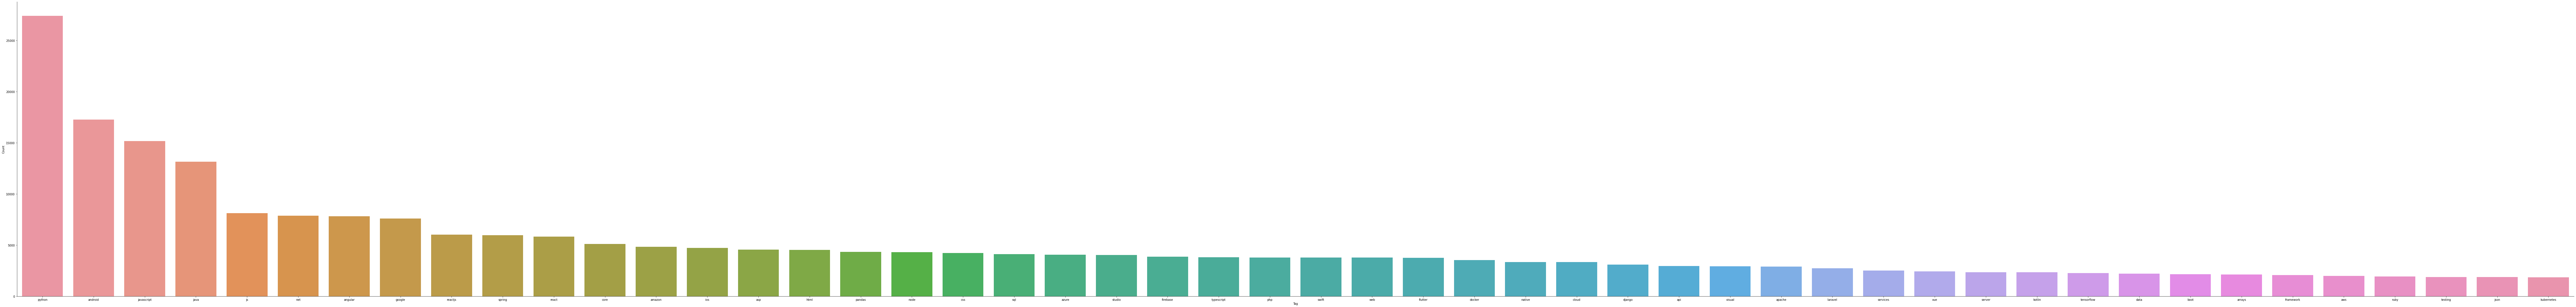

In [ ]:
#df_sorted = df_tags_count.sort_values(by='Count', ascending=False)

sns.catplot(x='Tag', y='Count', data=df_tags_count, kind='bar', height=15, aspect=10.7/1.27);


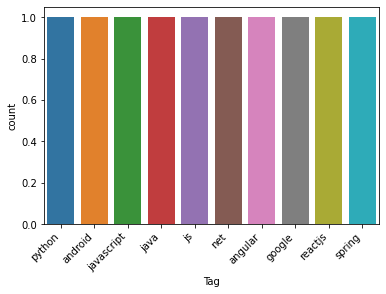

In [ ]:
ax  = sns.countplot(x = 'Tag', data = df_tags_count.head(10))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

Depuis le départ, on a seulement utilisé les fréquences d'apparition des différents mots/n-grammes présents dans notre corpus. Le problème est que si l'on veut vraiment représenter un document par les n-grammes qu'il contient, il faudrait le faire relativement à leur apparition dans les autres documents.

En effet, si un mot apparait dans d'autres documents, il est donc moins représentatif du document qu'un mot qui n'apparait que uniquement dans ce document.

I will be covering these topics in the project, but you can go through them before or during the project.

1. http://www.tfidf.com/ - Gives the formula for TF-IDF calculation and a simple example.

2. Difference between stemming and lemmatizing -

The goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form. However, the two words differ in their flavor. Stemming usually refers to a crude heuristic process that chops off the ends of words in the hope of achieving this goal correctly most of the time, and often includes the removal of derivational affixes. Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma.

## **TF-IDF**

Depuis le départ, on a seulement utilisé les fréquences d'apparition des différents mots/n-grammes présents dans notre corpus. Le problème est que si l'on veut vraiment représenter un document par les n-grammes qu'il contient, il faudrait le faire relativement à leur apparition dans les autres documents.

En effet, si un mot apparait dans d'autres documents, il est donc moins représentatif du document qu'un mot qui n'apparait que uniquement dans ce document.

I will be covering these topics in the project, but you can go through them before or during the project.

http://www.tfidf.com/ - Gives the formula for TF-IDF calculation and a simple example.

Difference between stemming and lemmatizing -

The goal of both stemming and lemmatization is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form. However, the two words differ in their flavor. Stemming usually refers to a crude heuristic process that chops off the ends of words in the hope of achieving this goal correctly most of the time, and often includes the removal of derivational affixes. Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma.